# Download Data

In [1]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EfREjZqiZTlPqhqUPICBbPABdlgPumlaUVxPncm-_9aWIw?download=1 -O "Project 1 - data.zip"
!unzip -q "Project 1 - data.zip"

# Import Libraries

In [2]:
!pip -q install keras-layer-normalization

In [38]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization,\
    Activation, Input, Add, Concatenate, Embedding, Conv1D, MaxPool1D,\
    Flatten, LSTM, Bidirectional, MaxPooling1D, SimpleRNN, GRU, SpatialDropout1D
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# Data Loader

In [6]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [7]:
train_df = load_data('train', columns=['full'])
valid_df = load_data('valid', columns=['full'])
test_df = load_data('test', columns=['full'])

select [full] columns from the train split
Failed, then try to 
select all columns from the train split
select [full] columns from the valid split
Failed, then try to 
select all columns from the valid split
select [full] columns from the test split
Failed, then try to 
select all columns from the test split


# Feature Extractor

In [8]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """

    return [ps.stem(token).lower() for token in tokens]

# Just for testing, was not used in tutorial - removing stopwords doesn't help much
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [9]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

# RNN Builder

In [10]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=True)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

# Create Input Features

In [11]:
min_freq = 3

# load data
train_texts, train_labels = train_df["text"], train_df["stars"]
valid_texts, valid_labels = valid_df["text"], valid_df["stars"]

# extract features
train_tokens = [tokenize(text) for text in train_texts]
valid_tokens = [tokenize(text) for text in valid_texts]


train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]

# If stopwords not used
train_feats = train_stemmed
valid_feats = valid_stemmed

# filtering stopwords didn't help much
# train_feats = [filter_stopwords(tokens) for tokens in train_stemmed]
# valid_feats = [filter_stopwords(tokens) for tokens in valid_stemmed]

# build a mapping from features to indices
feats_dict = get_feats_dict(chain.from_iterable(train_feats), min_freq=min_freq)

Size of features: 9357


In [12]:
max_len = 100

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

# RNN

In [33]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="rnn", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

print(model.summary())

np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 100)          935700    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
activation_8 (Activation)    (None, 100)               0   

# LSTM

In [14]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 5ms/step - loss: 1.4779 - accuracy: 0.5095
training loss: 1.2196249961853027 training accuracy 0.5995000004768372
valid loss: 1.4779484272003174 valid accuracy 0.5095000267028809


# GRU

In [15]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
gru_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 5ms/step - loss: 1.8844 - accuracy: 0.4880
training loss: 0.5286101698875427 training accuracy 0.845300018787384
valid loss: 1.8844343423843384 valid accuracy 0.4880000054836273


RNN vs LSTM vs GRU

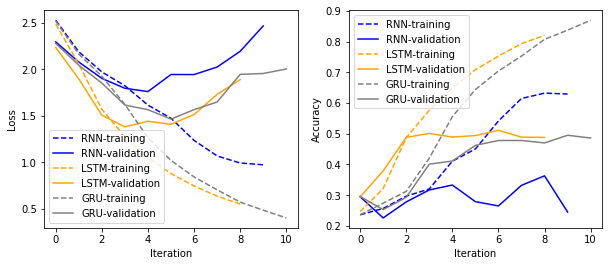

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(rnn_history.history["loss"], label="RNN-training", color="blue", linestyle="dashed")
plt.plot(rnn_history.history["val_loss"], label="RNN-validation", color="blue")
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["loss"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(rnn_history.history["accuracy"], label="RNN-training", color="blue", linestyle="dashed")
plt.plot(rnn_history.history["val_accuracy"], label="RNN-validation", color="blue")
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["accuracy"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Bidirectional LSTM

In [13]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 9ms/step - loss: 1.3064 - accuracy: 0.5355
training loss: 0.9228719472885132 training accuracy 0.7652000188827515
valid loss: 1.3063894510269165 valid accuracy 0.5354999899864197


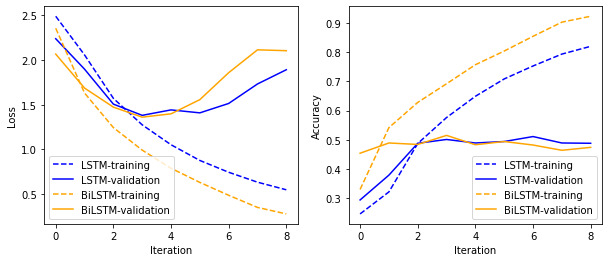

In [48]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Word2Vec

Add word2vec embeddings and tune hyperparameters

In [13]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip
%cd fastText-0.9.2
!make

--2021-04-03 04:33:39--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2 [following]
--2021-04-03 04:33:39--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip’

v0.9.2.zip              [  <=>               ]   4.17M  18.4MB/s    in 0.2s    

2021-04-03 04:33:39 (18.4 MB/s) - ‘v0.9.2.zip’ saved [4369852]

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
   creating: fastText-0.9.2/
   creating: fastText-0.9.2/.circleci/
  inflating: fastText-0

In [14]:
!cp fasttext ../
%cd ..

/content


In [15]:
with open('reviews.txt', 'w') as filehandle:
    for sent in train_feats:
        combined_sent = (" ").join(sent)
        filehandle.write('%s\n' % combined_sent)

In [16]:
os.makedirs("models", exist_ok=True)

In [17]:
!./fasttext skipgram -input ./reviews.txt -output models/word2vec -dim 100 -minCount 3 -epoch 10

Read 1M words
Number of words:  9356
Number of labels: 0
Progress: 100.0% words/sec/thread:   20808 lr:  0.000000 avg.loss:  2.334646 ETA:   0h 0m 0s


In [18]:
embedding_matrix = np.zeros((len(feats_dict), 100), dtype=np.float32)
with open("models/word2vec.vec", "r") as f:
    n_words, n_dim = f.readline().split()
    n_words, n_dim = int(n_words), int(n_dim) 
    print("number of words:", n_words, "word dimension:", n_dim)
    while True:
        line = f.readline()
        if not line:
            break
        word, vec = line.split(" ", 1)
        word_idx = feats_dict.get(word, -1)
        if word_idx != -1:
            embedding_matrix[word_idx] = np.array(vec.split(), dtype=np.float32)

number of words: 9356 word dimension: 100


In [19]:
print(embedding_matrix[:5])

[[ 0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.        

Word2Vec + BiLSTM

In [25]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=2, bidirectional=True, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_word2vec.hdf5"),
    monitor="val_loss",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

print(model.summary())

np.random.seed(0)
tf.random.set_seed(0)
word2vec_bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights_word2vec.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 100)          935700    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               2010

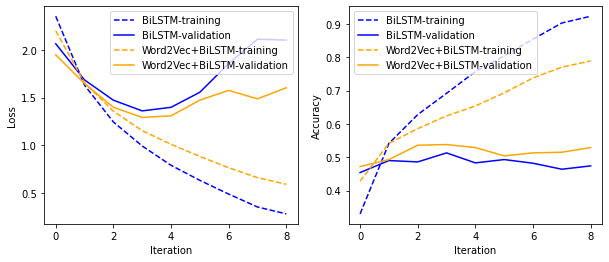

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["loss"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_loss"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["accuracy"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_accuracy"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Trying concat(emb + lstm) + conv1D + maxPooling + Dense 

In [27]:
input_length = max_len
vocab_size = len(feats_dict)
embedding_size = 100
hidden_size = 100
num_filters = 100
kernel_size = 2
strides = 1
output_size = num_classes
dropout_rate = 0.5
recurrent_dropout_rate = 0.5

In [28]:
x = Input(shape=(input_length,))
if embedding_matrix is not None:
    emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=True)(x)
else:
    emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    input_length=input_length,
                    embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)

emb = Dropout(dropout_rate)(emb)

rec = Bidirectional(LSTM(hidden_size,
                    kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                    recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                    return_sequences=True, dropout=dropout_rate, recurrent_activation="sigmoid"))(emb)

h = Concatenate()([emb, rec])

print(h.shape)

conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", strides=strides)(h)

conv = Activation("tanh")(conv)
    
maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)

maxpool = Flatten()(maxpool)

y = Dense(output_size,
          activation="softmax",
          kernel_initializer=keras.initializers.he_normal(seed=0),
          bias_initializer="zeros")(maxpool)

model = Model(x, y)
# optimizer = keras.optimizers.SGD(lr=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
model.summary()

(None, 100, 300)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 100)     935700      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 100, 100)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 100, 200)     160800      dropout_8[0][0]                  
___________________________________________________________________________

In [29]:
os.makedirs("models", exist_ok=True)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_word2vec_cnn.hdf5"),
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1)

np.random.seed(0)
tf.random.set_seed(0)
word2vec_bilstm_cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=1,
                                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights_word2vec_cnn.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Epoch 1/100
90/90 [==============================] - 6s 33ms/step - loss: 1.5205 - accuracy: 0.3337 - val_loss: 1.2870 - val_accuracy: 0.4520

Epoch 00001: val_accuracy improved from -inf to 0.45200, saving model to models/weights_word2vec_cnn.hdf5
Epoch 2/100
90/90 [==============================] - 2s 25ms/step - loss: 1.2234 - accuracy: 0.4887 - val_loss: 1.1244 - val_accuracy: 0.5070

Epoch 00002: val_accuracy improved from 0.45200 to 0.50700, saving model to models/weights_word2vec_cnn.hdf5
Epoch 3/100
90/90 [==============================] - 2s 24ms/step - loss: 1.1354 - accuracy: 0.5279 - val_loss: 1.2218 - val_accuracy: 0.4890

Epoch 00003: val_accuracy did not improve from 0.50700
Epoch 4/100
90/90 [==============================] - 2s 24ms/step - loss: 1.1120 - accuracy: 0.5285 - val_loss: 1.0829 - val_accuracy: 0.5350

Epoch 00004: val_accuracy improved from 0.50700 to 0.53500, saving model to models/weights_word2vec_cnn.hdf5
Epoch 5/100
90/90 [==============================

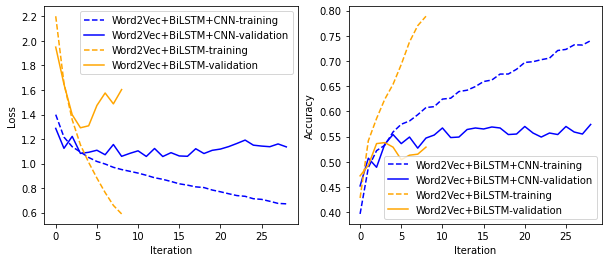

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(word2vec_bilstm_cnn_history.history["loss"], label="Word2Vec+BiLSTM+CNN-training", color="blue", linestyle="dashed")
plt.plot(word2vec_bilstm_cnn_history.history["val_loss"], label="Word2Vec+BiLSTM+CNN-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["loss"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_loss"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(word2vec_bilstm_cnn_history.history["accuracy"], label="Word2Vec+BiLSTM+CNN-training", color="blue", linestyle="dashed")
plt.plot(word2vec_bilstm_cnn_history.history["val_accuracy"], label="Word2Vec+BiLSTM+CNN-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["accuracy"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_accuracy"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# LSTM + CNN

In [20]:
def Emb_Lstm_Cnn_Mlp(input_length=max_len, vocab_size=len(feats_dict), 
                     embedding_size=100, hidden_size=100, 
                     num_filters=100, kernel_size=2, strides=1, 
                     output_size=num_classes, learning_rate=0.001,
                     dropout_rate=0.5, recurrent_dropout_rate=0.5, 
                     train=False, optimizer="RMSprop"):
    x = Input(shape=(input_length,))
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                            output_dim=embedding_size,
                            input_length=input_length,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            trainable=train)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)

    emb = Dropout(dropout_rate)(emb)

    rec = Bidirectional(LSTM(hidden_size,
                        kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                        recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                        return_sequences=True, dropout=dropout_rate, recurrent_activation="sigmoid"))(emb)

    h = Concatenate()([emb, rec])

    # h = Dropout(dropout_rate)(h)

    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", strides=strides)(h)

    conv = Activation("relu")(conv)
        
    maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
    # maxpool = MaxPool1D()(conv)

    maxpool = Flatten()(maxpool)

    maxpool = Dropout(dropout_rate)(maxpool) # testing

    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(maxpool)

    model = Model(x, y)
    # optimizer = keras.optimizers.Adam(lr=learning_rate)
    # optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    # print(model.summary())
    return model

In [32]:
model = Emb_Lstm_Cnn_Mlp(learning_rate=0.001, train=True)

In [33]:
os.makedirs("models", exist_ok=True)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_word2vec_cnn.hdf5"),
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1)

model = Emb_Lstm_Cnn_Mlp(train=True)
word2vec_bilstm_cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=1,
                                    callbacks=[checkpointer, earlystopping, reduce_lr])
model = keras.models.load_model(os.path.join("models", "weights_word2vec_cnn.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Epoch 1/100
90/90 [==============================] - 6s 33ms/step - loss: 1.6628 - accuracy: 0.2743 - val_loss: 1.4560 - val_accuracy: 0.3290

Epoch 00001: val_accuracy improved from -inf to 0.32900, saving model to models/weights_word2vec_cnn.hdf5
Epoch 2/100
90/90 [==============================] - 2s 24ms/step - loss: 1.3330 - accuracy: 0.4419 - val_loss: 1.2492 - val_accuracy: 0.4920

Epoch 00002: val_accuracy improved from 0.32900 to 0.49200, saving model to models/weights_word2vec_cnn.hdf5
Epoch 3/100
90/90 [==============================] - 2s 24ms/step - loss: 1.2282 - accuracy: 0.4716 - val_loss: 1.1913 - val_accuracy: 0.5300

Epoch 00003: val_accuracy improved from 0.49200 to 0.53000, saving model to models/weights_word2vec_cnn.hdf5
Epoch 4/100
90/90 [==============================] - 2s 24ms/step - loss: 1.1931 - accuracy: 0.4989 - val_loss: 1.1725 - val_accuracy: 0.5170

Epoch 00004: val_accuracy did not improve from 0.53000
Epoch 5/100
90/90 [==============================

## Best LSTM + CNN model till now

In [34]:
# model_almost_best_lstm_cnn = Emb_Lstm_Cnn_Mlp(learning_rate=0.001, train=True, hidden_size=100)

!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EZ31mNhwpkZLt4tBq0GKt_kBlqE6fQWSIu8W9_AiDi70fA?download=1 -O "weights_word2vec_cnn.hdf5"

model_almost_best_lstm_cnn = keras.models.load_model(os.path.join("weights_word2vec_cnn.hdf5"))

train_score = model_almost_best_lstm_cnn.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model_almost_best_lstm_cnn.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 8ms/step - loss: 0.9691 - accuracy: 0.6085
training loss: 0.7158880233764648 training accuracy 0.7224000096321106
valid loss: 0.9690638780593872 valid accuracy 0.6085000038146973


## Test Embeddings trainable or Not

In [21]:
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0)

In [40]:
embs = [False, True]
embs_histories = []

for e in embs:
    model = Emb_Lstm_Cnn_Mlp(train=e)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_lstm_cnn_" + str(e) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping, reduce_lr])
    
    model = keras.models.load_model(os.path.join("models", "weights_lstm_cnn_" + str(e) + ".hdf5"))
    embs_histories.append((e, history))

    print("Embedding Trainable:", str(e))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Embedding Trainable: False
20/20 [==============================] - 0s 8ms/step - loss: 1.0529 - accuracy: 0.5710
training loss: 1.0379812717437744 training accuracy 0.5910999774932861
valid loss: 1.0528535842895508 valid accuracy 0.5709999799728394
Embedding Trainable: True
20/20 [==============================] - 0s 9ms/step - loss: 0.9623 - accuracy: 0.5980
training loss: 0.882178783416748 training accuracy 0.649399995803833
valid loss: 0.9623134732246399 valid accuracy 0.5979999899864197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

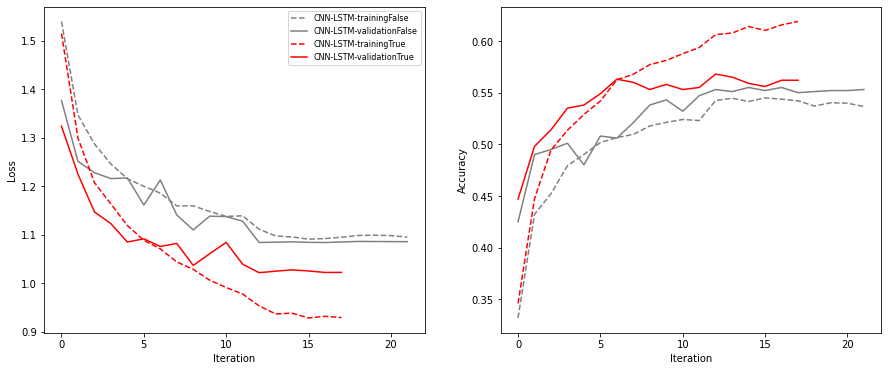

In [41]:
colors = ["gray", "red"]
plt.figure(figsize=(15,6))

for i, (e, history) in enumerate(embs_histories):
    name = str(e)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="CNN-LSTM-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="CNN-LSTM-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

Trainable=True val accuracy is better than Trainable=False

Thus, propogating that for further experiments

## Test Dropout

In [43]:
dropouts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
drop_histories = []

for d in dropouts:
    model = Emb_Lstm_Cnn_Mlp(train=True, dropout_rate=d)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_lstm_cnn_drop_" + str(d) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping, reduce_lr])
    
    model = keras.models.load_model(os.path.join("models", "weights_lstm_cnn_drop_" + str(d) + ".hdf5"))
    drop_histories.append((d, history))

    print("Dropout Rate:", str(d))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Dropout Rate: 0.2
20/20 [==============================] - 0s 9ms/step - loss: 1.0009 - accuracy: 0.5685
training loss: 0.775955319404602 training accuracy 0.6973999738693237
valid loss: 1.0009468793869019 valid accuracy 0.5684999823570251
Dropout Rate: 0.3
20/20 [==============================] - 0s 9ms/step - loss: 0.9543 - accuracy: 0.5880
training loss: 0.687696099281311 training accuracy 0.743399977684021
valid loss: 0.9543026685714722 valid accuracy 0.5879999995231628
Dropout Rate: 0.4
20/20 [==============================] - 0s 8ms/step - loss: 0.9487 - accuracy: 0.5880
training loss: 0.7813793420791626 training accuracy 0.6937000155448914
valid loss: 0.9487497806549072 valid accuracy 0.5879999995231628
Dropout Rate: 0.5
20/20 [==============================] - 0s 9ms/step - loss: 0.9663 - accuracy: 0.5915
training loss: 0.881061315536499 training accuracy 0.6492999792098999
valid loss: 0.9662863612174988 valid accuracy 0.5914999842643738
Dropout Rate: 0.6
20/20 [===============

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

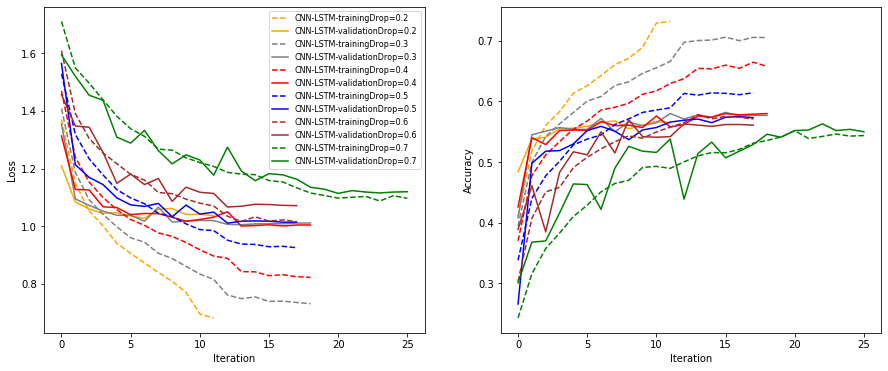

In [44]:
colors = ["orange", "gray", "red", "blue", "brown", "green"]
plt.figure(figsize=(15,6))

for i, (d, history) in enumerate(drop_histories):
    name = "Drop=" + str(d)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="CNN-LSTM-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="CNN-LSTM-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

Dropout Rate = 0.5 performs the best

## Test num_filters

In [45]:
filters = [32, 64, 128, 256, 512]
filter_histories = []

for f in filters:
    model = Emb_Lstm_Cnn_Mlp(train=True, dropout_rate=0.5, num_filters=f)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_lstm_cnn_filters_" + str(f) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping, reduce_lr])
    
    model = keras.models.load_model(os.path.join("models", "weights_lstm_cnn_filters_" + str(f) + ".hdf5"))
    filter_histories.append((f, history))

    print("No of Filters:", str(f))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

No of Filters: 32
20/20 [==============================] - 0s 9ms/step - loss: 0.9911 - accuracy: 0.5905
training loss: 0.9407694339752197 training accuracy 0.6233000159263611
valid loss: 0.991077184677124 valid accuracy 0.590499997138977
No of Filters: 64
20/20 [==============================] - 0s 8ms/step - loss: 0.9612 - accuracy: 0.5975
training loss: 0.8862734436988831 training accuracy 0.6384999752044678
valid loss: 0.9612253904342651 valid accuracy 0.5975000262260437
No of Filters: 128
20/20 [==============================] - 0s 9ms/step - loss: 0.9558 - accuracy: 0.5895
training loss: 0.8793660402297974 training accuracy 0.650600016117096
valid loss: 0.9558082818984985 valid accuracy 0.5895000100135803
No of Filters: 256
20/20 [==============================] - 0s 10ms/step - loss: 0.9462 - accuracy: 0.5900
training loss: 0.7428390979766846 training accuracy 0.7311999797821045
valid loss: 0.9461690783500671 valid accuracy 0.5899999737739563
No of Filters: 512
20/20 [==========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

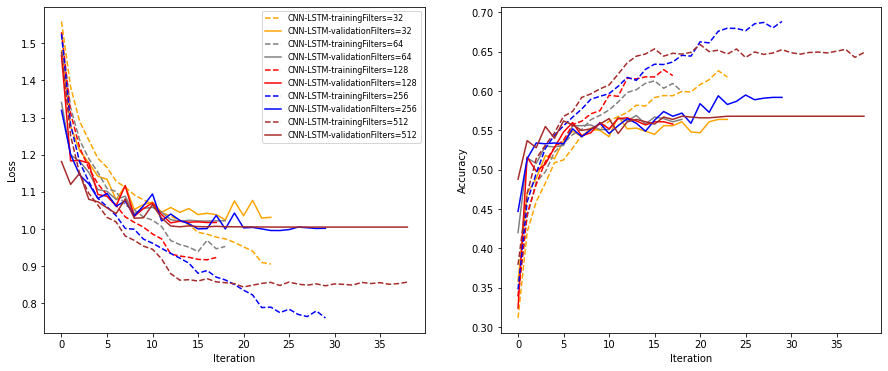

In [46]:
colors = ["orange", "gray", "red", "blue", "brown"]
plt.figure(figsize=(15,6))

for i, (f, history) in enumerate(filter_histories):
    name = "Filters=" + str(f)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="CNN-LSTM-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="CNN-LSTM-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

According to graphs, filters = 256 performs the best

Thus, propogating it for further testing

## Test Kernel Size 

In [47]:
kernel_sizes = [1, 2, 4, 7, 10, 20]
kernel_histories = []

for k in kernel_sizes:
    model = Emb_Lstm_Cnn_Mlp(train=True, dropout_rate=0.5, num_filters=256, kernel_size=k)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_lstm_cnn_kernel_" + str(k) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping, reduce_lr])
    
    model = keras.models.load_model(os.path.join("models", "weights_lstm_cnn_kernel_" + str(k) + ".hdf5"))
    kernel_histories.append((k, history))

    print("Kernel Size:", str(k))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])


No of Filters: 1
20/20 [==============================] - 0s 10ms/step - loss: 0.9642 - accuracy: 0.5935
training loss: 0.8781918883323669 training accuracy 0.6565999984741211
valid loss: 0.9642174243927002 valid accuracy 0.593500018119812
No of Filters: 2
20/20 [==============================] - 0s 9ms/step - loss: 1.0086 - accuracy: 0.5840
training loss: 0.9556629061698914 training accuracy 0.6226999759674072
valid loss: 1.008610725402832 valid accuracy 0.5839999914169312
No of Filters: 4
20/20 [==============================] - 0s 10ms/step - loss: 0.9838 - accuracy: 0.5900
training loss: 0.8972615003585815 training accuracy 0.6531999707221985
valid loss: 0.9837874174118042 valid accuracy 0.5899999737739563
No of Filters: 7
20/20 [==============================] - 0s 10ms/step - loss: 0.9892 - accuracy: 0.5875
training loss: 0.8252298831939697 training accuracy 0.7056000232696533
valid loss: 0.989151656627655 valid accuracy 0.5874999761581421
No of Filters: 10
20/20 [===============

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

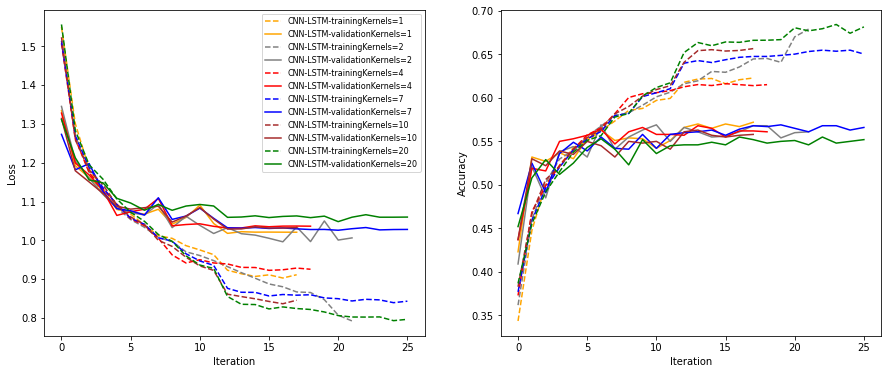

In [48]:
colors = ["orange", "gray", "red", "blue", "brown", "green"]
plt.figure(figsize=(15,6))

for i, (k, history) in enumerate(kernel_histories):
    name = "Kernels=" + str(k)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="CNN-LSTM-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="CNN-LSTM-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

Kernel Size = 1 performs the best

Thus, propogating it further

## Test Strides

In [22]:
strides = [1, 2, 4, 7, 10, 20]
strides_histories = []

for s in strides:
    model = Emb_Lstm_Cnn_Mlp(train=True, dropout_rate=0.5, num_filters=256, kernel_size=1,strides=s)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_lstm_cnn_strides_" + str(s) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping, reduce_lr])
    
    model = keras.models.load_model(os.path.join("models", "weights_lstm_cnn_strides_" + str(s) + ".hdf5"))
    strides_histories.append((s, history))

    print("Strides:", str(s))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])


Strides: 1
20/20 [==============================] - 0s 9ms/step - loss: 1.0450 - accuracy: 0.5725
training loss: 1.018115520477295 training accuracy 0.6080999970436096
valid loss: 1.0449624061584473 valid accuracy 0.5724999904632568
Strides: 2
20/20 [==============================] - 0s 9ms/step - loss: 0.9603 - accuracy: 0.5920
training loss: 0.8204347491264343 training accuracy 0.6801999807357788
valid loss: 0.96030193567276 valid accuracy 0.5920000076293945
Strides: 4
20/20 [==============================] - 0s 9ms/step - loss: 0.9928 - accuracy: 0.5795
training loss: 0.8968362212181091 training accuracy 0.6431999802589417
valid loss: 0.9928432106971741 valid accuracy 0.5795000195503235
Strides: 7
20/20 [==============================] - 0s 8ms/step - loss: 0.9782 - accuracy: 0.5895
training loss: 0.8658351302146912 training accuracy 0.6503999829292297
valid loss: 0.9782135486602783 valid accuracy 0.5895000100135803
Strides: 10
20/20 [==============================] - 0s 9ms/step - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

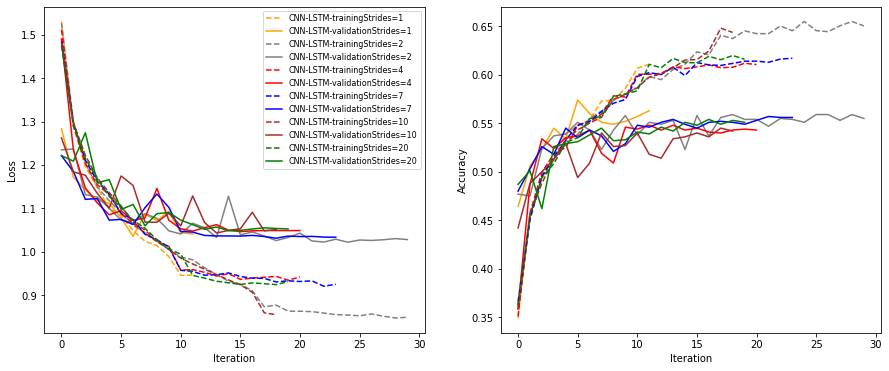

In [23]:
colors = ["orange", "gray", "red", "blue", "brown", "green"]
plt.figure(figsize=(15,6))

for i, (s, history) in enumerate(strides_histories):
    name = "Strides=" + str(s)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="CNN-LSTM-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="CNN-LSTM-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

Strides = 2 performs the best

## Test Hidden Size

In [24]:
hidden_sizes = [50, 200, 400, 800]
hid_histories = []

for h in hidden_sizes:
    model = Emb_Lstm_Cnn_Mlp(train=True, dropout_rate=0.5, num_filters=256, kernel_size=1,strides=2, hidden_size=h)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_lstm_cnn_hid_" + str(h) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping, reduce_lr])
    
    model = keras.models.load_model(os.path.join("models", "weights_lstm_cnn_hid_" + str(h) + ".hdf5"))
    hid_histories.append((h, history))

    print("Hidden Size:", str(h))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])


Hidden Size: 50
20/20 [==============================] - 0s 7ms/step - loss: 1.0087 - accuracy: 0.5740
training loss: 0.9217166900634766 training accuracy 0.6359999775886536
valid loss: 1.0086795091629028 valid accuracy 0.5740000009536743
Hidden Size: 200
20/20 [==============================] - 0s 11ms/step - loss: 0.9699 - accuracy: 0.5830
training loss: 0.8264487385749817 training accuracy 0.6776000261306763
valid loss: 0.9698810577392578 valid accuracy 0.5830000042915344
Hidden Size: 400
20/20 [==============================] - 0s 22ms/step - loss: 0.9585 - accuracy: 0.5820
training loss: 0.7703689336776733 training accuracy 0.7027999758720398
valid loss: 0.958518922328949 valid accuracy 0.5820000171661377
Hidden Size: 800
20/20 [==============================] - 1s 58ms/step - loss: 0.9525 - accuracy: 0.5905
training loss: 0.7784967422485352 training accuracy 0.6937999725341797
valid loss: 0.9524871706962585 valid accuracy 0.590499997138977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

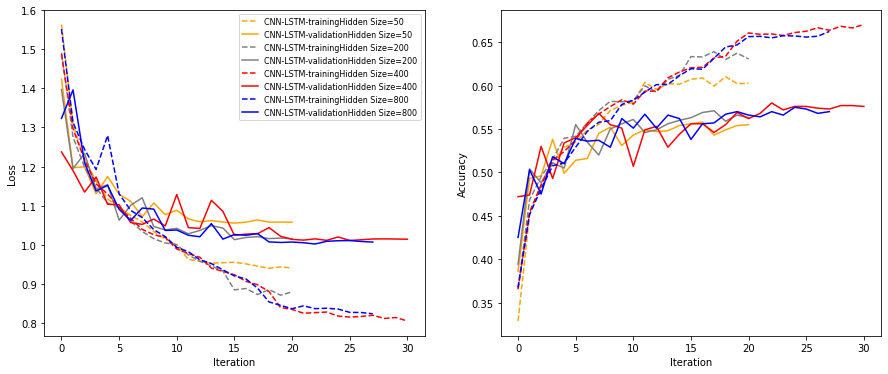

In [25]:
colors = ["orange", "gray", "red", "blue"]
plt.figure(figsize=(15,6))

for i, (h, history) in enumerate(hid_histories):
    name = "Hidden Size=" + str(h)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="CNN-LSTM-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="CNN-LSTM-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="CNN-LSTM-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

Hidden Size = 400 performs the best

## Make a model combining all tuned hyperparameters

In [40]:
os.makedirs("models", exist_ok=True)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_word2vec_cnn_lstm_tuned.hdf5"),
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

model = Emb_Lstm_Cnn_Mlp(train=True, dropout_rate=0.5, num_filters=64, kernel_size=1,strides=2, hidden_size=100)
word2vec_bilstm_cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=1,
                                    callbacks=[checkpointer, earlystopping, reduce_lr])
model = keras.models.load_model(os.path.join("models", "weights_word2vec_cnn_lstm_tuned.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Epoch 1/100
90/90 [==============================] - 5s 31ms/step - loss: 1.6913 - accuracy: 0.2614 - val_loss: 1.3639 - val_accuracy: 0.4430

Epoch 00001: val_accuracy improved from -inf to 0.44300, saving model to models/weights_word2vec_cnn_lstm_tuned.hdf5
Epoch 2/100
90/90 [==============================] - 2s 23ms/step - loss: 1.3872 - accuracy: 0.4163 - val_loss: 1.2125 - val_accuracy: 0.5080

Epoch 00002: val_accuracy improved from 0.44300 to 0.50800, saving model to models/weights_word2vec_cnn_lstm_tuned.hdf5
Epoch 3/100
90/90 [==============================] - 2s 23ms/step - loss: 1.2829 - accuracy: 0.4607 - val_loss: 1.1651 - val_accuracy: 0.4860

Epoch 00003: val_accuracy did not improve from 0.50800
Epoch 4/100
90/90 [==============================] - 2s 23ms/step - loss: 1.2291 - accuracy: 0.4874 - val_loss: 1.1666 - val_accuracy: 0.5190

Epoch 00004: val_accuracy improved from 0.50800 to 0.51900, saving model to models/weights_word2vec_cnn_lstm_tuned.hdf5
Epoch 5/100
90/9

## Best tuned model

In [32]:
# model = Emb_Lstm_Cnn_Mlp(train=True, dropout_rate=0.5, num_filters=128, kernel_size=1,strides=2, hidden_size=200)

!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EarGeAFRGRpJtfYS4SpP9isB2tINH7WJyw6DJxXCLrL4sg?download=1 -O "weights_word2vec_cnn_lstm_tuned.hdf5"

model_best_tuned_lstm_cnn = keras.models.load_model(os.path.join("weights_word2vec_cnn_lstm_tuned.hdf5"))

train_score = model_best_tuned_lstm_cnn.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model_best_tuned_lstm_cnn.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 10ms/step - loss: 0.9507 - accuracy: 0.6015
training loss: 0.7885215878486633 training accuracy 0.6919000148773193
valid loss: 0.9506521224975586 valid accuracy 0.6014999747276306


## Modifying model architecture a bit

In [46]:
def Emb_Lstm_Cnn_Mlp_modified(input_length=max_len, vocab_size=len(feats_dict), 
                     embedding_size=100, hidden_size=100, 
                     num_filters=100, kernel_size=2, strides=1, 
                     output_size=num_classes, learning_rate=0.001,
                     dropout_rate=0.5, recurrent_dropout_rate=0.5, 
                     train=False, optimizer="RMSprop"):
    x = Input(shape=(input_length,))
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                            output_dim=embedding_size,
                            input_length=input_length,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            trainable=train)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)

    emb = SpatialDropout1D(dropout_rate)(emb)

    rec = Bidirectional(LSTM(hidden_size,
                        kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                        recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                        return_sequences=True, dropout=dropout_rate, recurrent_activation="sigmoid"))(emb)

    h = Concatenate()([emb, rec])

    # h = Dropout(dropout_rate)(h)

    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", strides=strides)(h)

    conv = Activation("relu")(conv)
        
    maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
    # maxpool = MaxPool1D()(conv)

    maxpool = Flatten()(maxpool)

    # maxpool = Dropout(dropout_rate)(maxpool) # testing

    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(maxpool)

    model = Model(x, y)
    # optimizer = keras.optimizers.Adam(lr=learning_rate)
    # optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    # print(model.summary())
    return model

In [51]:
os.makedirs("models", exist_ok=True)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_word2vec_cnn_lstm_mod.hdf5"),
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

model = Emb_Lstm_Cnn_Mlp_modified(train=True, dropout_rate=0.1, num_filters=64, kernel_size=1,strides=2, hidden_size=200)
word2vec_bilstm_cnn_mod_history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=1,
                                    callbacks=[checkpointer, earlystopping, reduce_lr])
model = keras.models.load_model(os.path.join("models", "weights_word2vec_cnn_lstm_mod.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Epoch 1/100
90/90 [==============================] - 7s 40ms/step - loss: 1.4730 - accuracy: 0.3532 - val_loss: 1.3331 - val_accuracy: 0.4450

Epoch 00001: val_accuracy improved from -inf to 0.44500, saving model to models/weights_word2vec_cnn_lstm_mod.hdf5
Epoch 2/100
90/90 [==============================] - 3s 32ms/step - loss: 1.1697 - accuracy: 0.5214 - val_loss: 1.1705 - val_accuracy: 0.5030

Epoch 00002: val_accuracy improved from 0.44500 to 0.50300, saving model to models/weights_word2vec_cnn_lstm_mod.hdf5
Epoch 3/100
90/90 [==============================] - 3s 32ms/step - loss: 1.0407 - accuracy: 0.5672 - val_loss: 1.0856 - val_accuracy: 0.5410

Epoch 00003: val_accuracy improved from 0.50300 to 0.54100, saving model to models/weights_word2vec_cnn_lstm_mod.hdf5
Epoch 4/100
90/90 [==============================] - 3s 32ms/step - loss: 0.9635 - accuracy: 0.6063 - val_loss: 1.0695 - val_accuracy: 0.5390

Epoch 00004: val_accuracy did not improve from 0.54100
Epoch 5/100
90/90 [===